# Clustering fraud detection

### This notebook is based on [this blogpost](https://www.toptal.com/machine-learning/generative-adversarial-networks) and its [github repo](https://github.com/codyznash/GANs_for_Credit_Card_Data).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import pickle
import xgboost as xgb

# load clustering libraries
import sklearn.cluster as cluster

# hdbscan not in kaggle/python at present
#!pip install hdbscan
import hdbscan

In [3]:
# Load engineered dataset from EDA section
data = pickle.load(open('./credicard.engineered.pkl','rb'))

In [4]:
# define the columns we want to test on, in case we want to use less than the full set
test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]
print(len(test_cols))
print(test_cols)

31
Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')


In [5]:
# data columns will be all other columns except class
label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('\n# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
('\n# of data columns: ', 30)


In [6]:
# Set up training set to consist of only fraud data
train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    492


In [7]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

CPU times: user 5.73 s, sys: 31.1 ms, total: 5.77 s
Wall time: 5.78 s


(0, 'KMeans 3')
(1, 'Agglomerative')
(2, 'HDBSCAN')


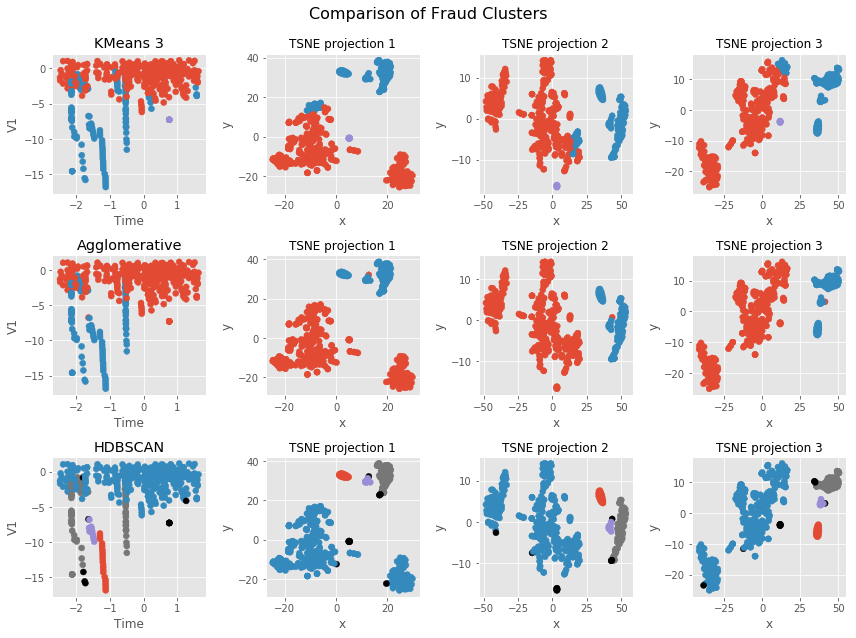

CPU times: user 1.94 s, sys: 39.4 ms, total: 1.98 s
Wall time: 1.98 s


In [8]:
%%time 
#!pip install ipdb
# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
#    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(j) if j>-1 else 'black' for j in colors ]
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('./Fraud_Cluster_Diagram.png')
plt.show()

In [9]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

   count
0    357
1    135


In [12]:
fraud_w_classes.Class.value_counts()

0    357
1    135
Name: Class, dtype: int64

In [13]:
# Let's see which features are most useful for detecting differences between the classes:
dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )

('Top eight features: ', [['V17', 10], ['V10', 5], ['V7', 5], ['V3', 2], ['V4', 2], ['V28', 1], ['V11', 1], ['V15', 1]])


/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
